##### Exponential 

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.optimize import differential_evolution   
import matplotlib.pylab as plt
from matplotlib.pyplot import savefig
from matplotlib.lines import Line2D
from scipy.integrate import solve_ivp
import pandas as pd
import math 
from datetime import date
from scipy.integrate import solve_ivp
import sys
import os
import copy 
#!pip install lifelines
import seaborn as sns
import statistics
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from scipy import stats

In [2]:
# Reading data
df = pd.read_csv("Tumor_lengths.csv")
df = df.loc[~df['ID'].isin(['A1001','A1003', 'A1015', 'E1034'])] # remove patients with too few data points
df_anyue = pd.read_excel("Individual parameters_START_TKI patients_AYin.xlsx")
df_anyue = df_anyue[["PID","PD_Kg(/day)","PD_Kd(/day)","PD_Km(/day)"]]
df_anyue = df_anyue.rename(columns={"PID": "ID", "PD_Kg(/day)": "kg", "PD_Kd(/day)": "kd", "PD_Km(/day)": "km"})
df_anyue = df_anyue.loc[~df_anyue['ID'].isin(['A1001','A1003', 'A1015', 'E1034'])] # remove patients with too few data points
cols = df_anyue.columns.tolist()
cols[2],cols[3]=cols[3],cols[2] # swap kd and km so anyue's columns match ours
df_anyue = df_anyue[cols]



In [3]:
### population model
def system_ode_rk45(time, populations, params):
    Spop = populations[0]
    Rpop = populations[1]
    kg = params[0] #growth rate
    km = params[1] #mutation rate
    kd = params[2] #death rate

    dSpop_dt = Spop * (kg - km - kd)
    dRpop_dt = Rpop * kg + Spop * km
    return [dSpop_dt, dRpop_dt]

# Cost function
def cost_func_rk45(params, time, data):
    #initial_populations = params[3:]
    initial_populations = [params[3], data[0]-params[3]]

    tspan = [days[0], days[-1]]
    
    pred_data_rk = solve_ivp(system_ode_rk45, tspan, initial_populations, 
                             t_eval = np.ravel(days),  args = tuple([params[:3]]))
    
    if pred_data_rk.y.shape[1] == np.ravel(days).shape[0]:
        spop = pred_data_rk.y[0]
        rpop = pred_data_rk.y[1]
        sum_pops = spop + rpop
        sumsq_error = np.sum((sum_pops - data)**2)
        msq_error = sumsq_error/len(data)
        rmse = np.sqrt(msq_error)
    else: 
        msq_error = 1e30
        rmse = 1e30

    return msq_error

In [4]:
unique_IDs = df.ID.unique()
master_dictionary = {} # dictionary to store the optimized parameters for each patient

# Find optimal parameters for each patient
for id in unique_IDs:

    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    print("Working on patient: ",id," Number of data points: ", len(days))

    # fitting patient data to equations
    bounds = [(5e-4,5e-3), (1e-4,2e-1), (1e-3, 1e-1), (0.9*data[0], data[0]-1e-3), (1e-3, 0.1*data[0])]
    init_params = [9e-4, 1e-2, 1e-2, data[0]-1e-3, 1e-3] # (kg, km, kd, Spop_0, Rpop_0)
    opt_result = minimize(cost_func_rk45, init_params, args=(days, data), bounds = bounds, method="nelder-mead")
    master_dictionary[id] = opt_result.x.tolist() + [opt_result.fun] # store optimized parameters and cost function value

Working on patient:  A1002  Number of data points:  16
Working on patient:  A1004  Number of data points:  5
Working on patient:  A1006  Number of data points:  9
Working on patient:  A1007  Number of data points:  13
Working on patient:  A1008  Number of data points:  12
Working on patient:  A1009  Number of data points:  6
Working on patient:  A1011  Number of data points:  5
Working on patient:  A1012  Number of data points:  10
Working on patient:  A1013  Number of data points:  7
Working on patient:  A1014  Number of data points:  18
Working on patient:  A1016  Number of data points:  14
Working on patient:  A1017  Number of data points:  7
Working on patient:  E1008  Number of data points:  6
Working on patient:  E1012  Number of data points:  16


In [5]:
df_exp = pd.DataFrame.from_dict(master_dictionary, orient='index', 
                                     columns=['r','km','kd','spop_0','rpop','mse'])
df_exp

,r,km,kd,spop_0,rpop,mse
A1002,0.000724,0.007402,0.014494,58.699,0.001071,14.398617
A1004,0.000501,0.009944,0.013441,32.999,0.001000,0.010775
A1006,0.000500,0.031413,0.099933,97.599,0.003525,22.312482
A1007,0.002194,0.002565,0.007618,86.199,0.001000,12.239836
A1008,0.001139,0.004416,0.009401,60.999,0.001162,3.116146
A1009,0.005000,0.004227,0.017444,90.999,0.001000,1.118151
A1011,0.000991,0.000802,0.010659,65.999,0.001238,0.938384
A1012,0.000500,0.008095,0.005613,87.999,0.001648,23.774270
A1013,0.000500,0.006419,0.009204,88.999,0.001705,18.454887
A1014,0.000500,0.009752,0.023027,28.999,0.001787,2.535848


##### fitting exponential with DE

In [6]:
unique_IDs = df.ID.unique()
master_dictionary = {} # dictionary to store the optimized parameters for each patient 

# Find optimal parameters for each patient
for id in unique_IDs:

    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    max_value = max(data[0], data[-1])

    print("Working on patient:", id, " Number of data points:", len(days))
    #bounds = [(5e-4, 4e-3), (2.5e-3,2e-2), (2e-3, 5e-2),(0.95*data[0], data[0]-1e-3)] # r, km, kd, spop0, 
    bounds = [(9e-4, 5e-3), (2.5e-3,2e-2), (2e-3, 5e-2),(0.95*data[0], data[0]-1e-3)] # r, km, kd, spop0, 


    # Use differential_evolution to perform a random search
    opt_result = differential_evolution(cost_func_rk45, bounds, args=(days, data))
    # store the optimal parameters and the cost function value (last entry in list)
    master_dictionary[id] = opt_result.x.tolist() + [opt_result.fun]

Working on patient: A1002  Number of data points: 16
Working on patient: A1004  Number of data points: 5
Working on patient: A1006  Number of data points: 9
Working on patient: A1007  Number of data points: 13
Working on patient: A1008  Number of data points: 12
Working on patient: A1009  Number of data points: 6
Working on patient: A1011  Number of data points: 5
Working on patient: A1012  Number of data points: 10
Working on patient: A1013  Number of data points: 7
Working on patient: A1014  Number of data points: 18
Working on patient: A1016  Number of data points: 14
Working on patient: A1017  Number of data points: 7
Working on patient: E1008  Number of data points: 6
Working on patient: E1012  Number of data points: 16


In [7]:
df_exp = pd.DataFrame.from_dict(master_dictionary, orient='index', 
                                     columns=['r','km','kd','spop_0','mse'])
df_exp

,r,km,kd,spop_0,mse
A1002,0.002876,0.002500,0.050000,13865.424789,2.827430e+06
A1004,0.000900,0.002603,0.032529,5883.382162,8.499469e+01
A1006,0.000900,0.002500,0.050000,17991.892513,9.669929e+04
A1007,0.001233,0.009280,0.019932,12509.349477,3.077354e+05
A1008,0.001422,0.002545,0.022110,12043.677688,8.117085e+04
A1009,0.005000,0.004216,0.034550,17652.919739,5.732181e+05
A1011,0.000900,0.002500,0.030521,3911.953796,5.603175e+04
A1012,0.000900,0.003960,0.011509,15645.873939,2.253404e+06
A1013,0.000900,0.004117,0.042756,16672.190189,5.421079e+04
A1014,0.001890,0.002500,0.050000,271.832050,5.064389e+02


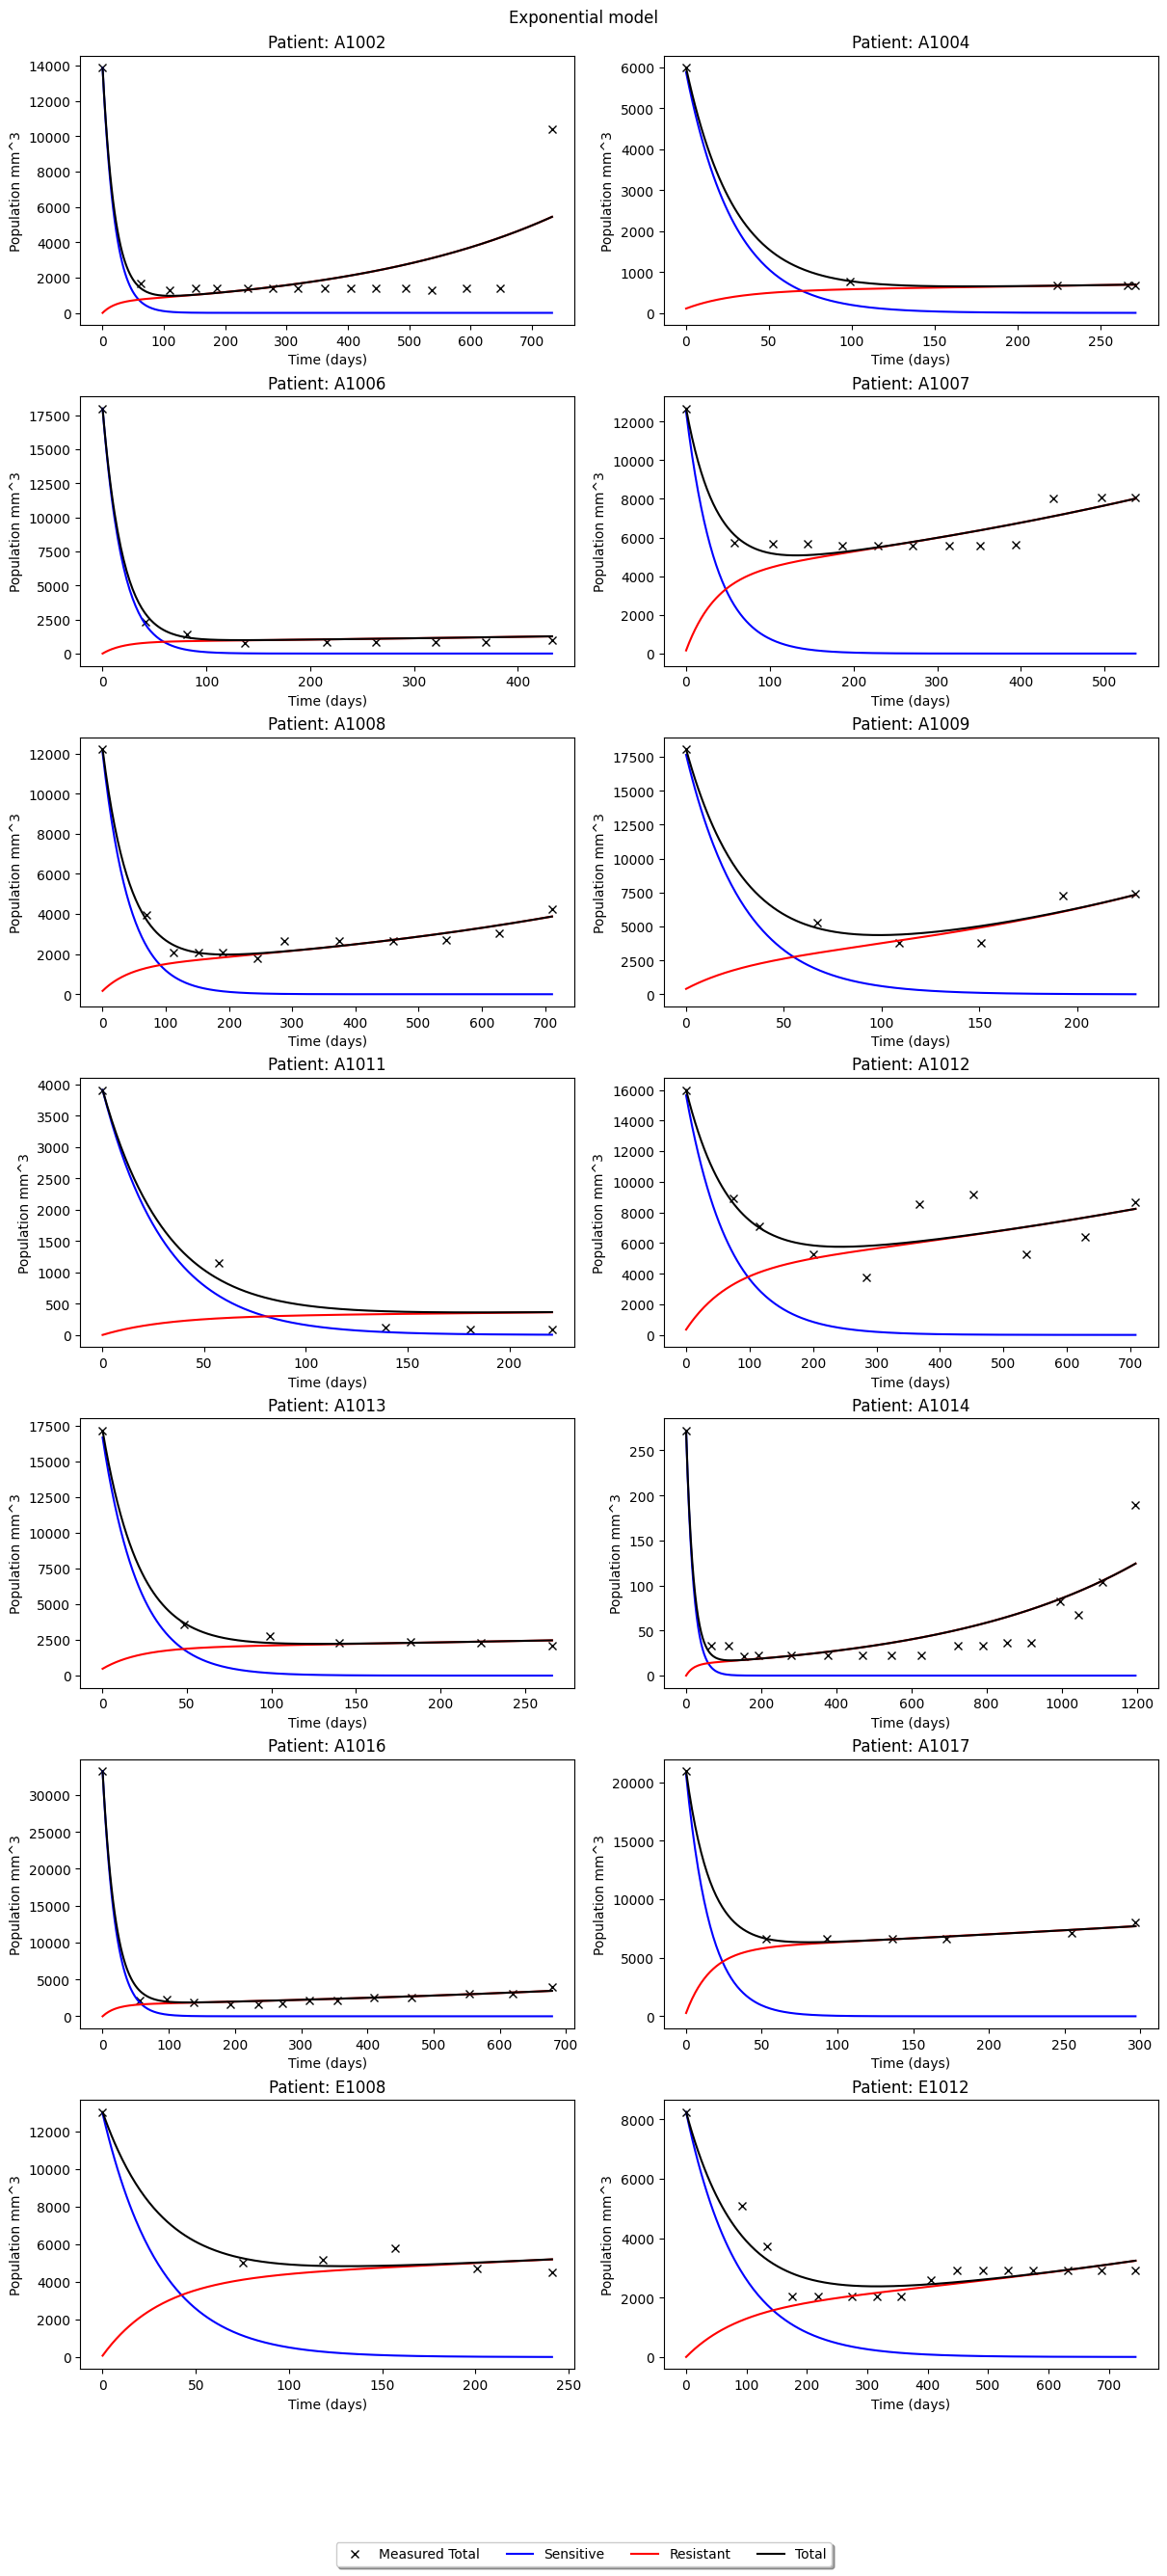

In [8]:
# setting up subplots   
n = len(unique_IDs)
ncols = 2
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(12,25), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params = master_dictionary[id]
    init_populations = [optimal_params[3], data[0]-optimal_params[3]]

    pred_data = solve_ivp(system_ode_rk45, [0,days[-1]],
                            init_populations, dense_output=True,
                            args = tuple([optimal_params[:3]]))
    sum_pops = np.sum(pred_data.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data.sol(tspan)[0], 'b-', label='Sensitive')
    ax.plot(tspan, pred_data.sol(tspan)[1], 'r-', label='Resistant') 
    ax.plot(tspan, sum_pops, 'k-', label='Total')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Population mm^3')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive'),
                   Line2D([0], [0], color='r', label='Resistant'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Exponential model')  
plt.show()

##### extending exponential
show how this is unrealistic

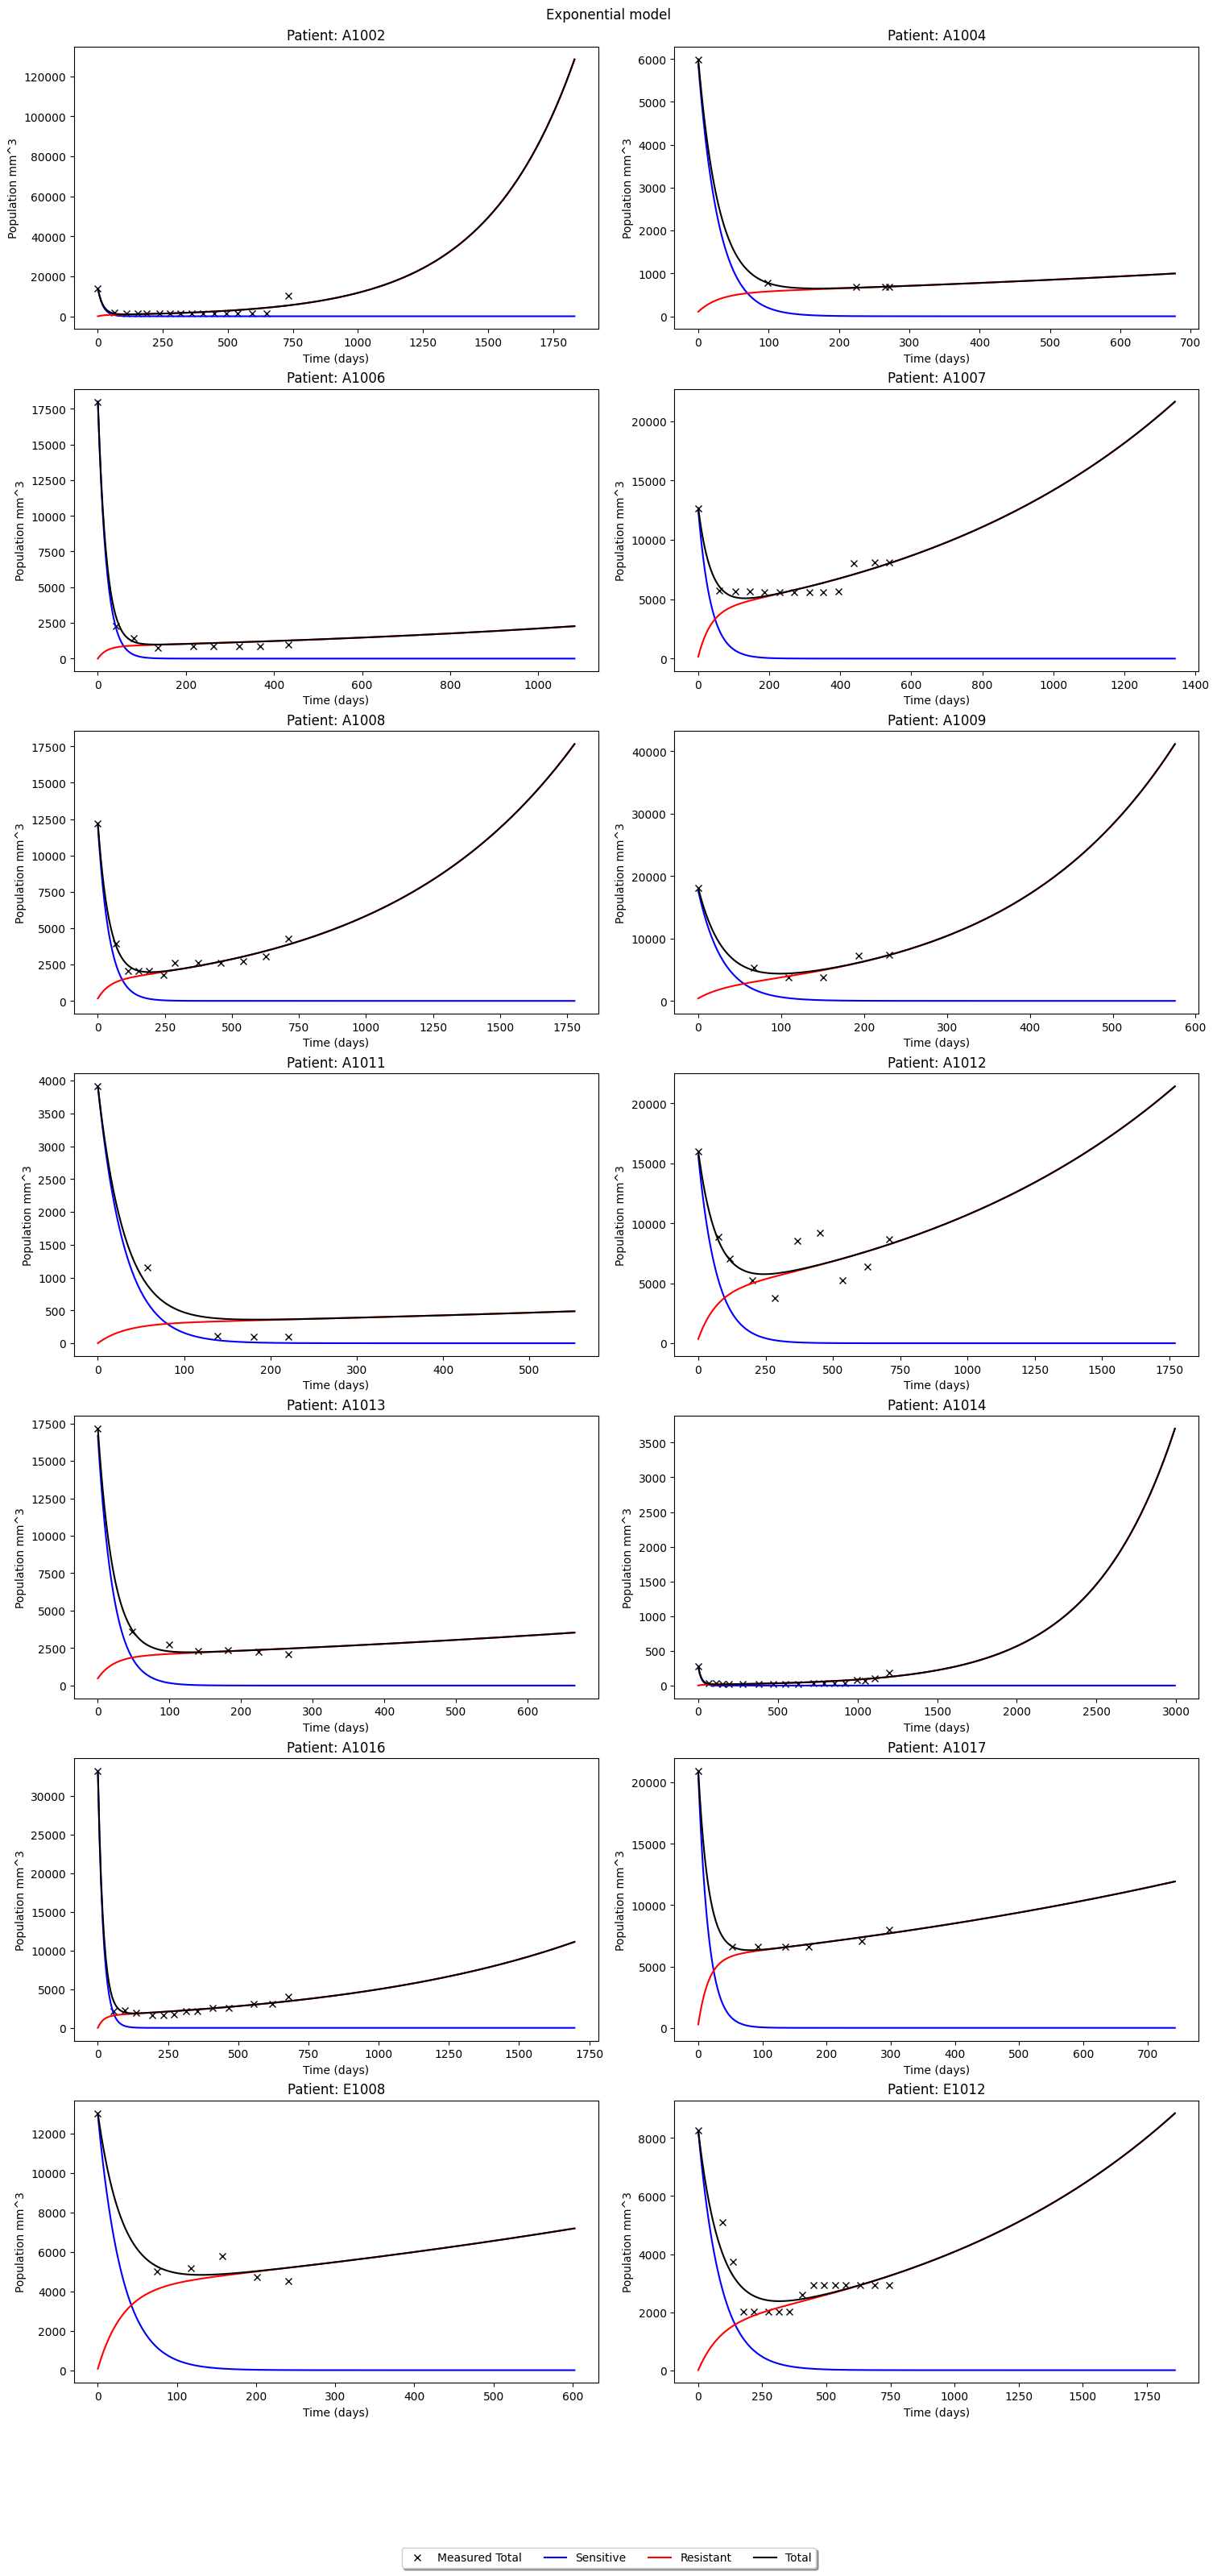

In [9]:
# setting up subplots   
n = len(unique_IDs)
ncols = 2
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 30), constrained_layout=True)

sim_time_factor = 2.5

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    tspan = np.linspace(0, sim_time_factor*days[-1], 300)

    optimal_params = master_dictionary[id]
    init_populations = [optimal_params[3], data[0]-optimal_params[3]]

    pred_data = solve_ivp(system_ode_rk45, [0,sim_time_factor*days[-1]],
                            init_populations, dense_output=True,
                            args = tuple([optimal_params[:3]]))
    sum_pops = np.sum(pred_data.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data.sol(tspan)[0], 'b-', label='Sensitive')
    ax.plot(tspan, pred_data.sol(tspan)[1], 'r-', label='Resistant') 
    ax.plot(tspan, sum_pops, 'k-', label='Total')
    #ax.axhline(y=1.1*data[0], color='r', linestyle='--') ### line to show progression

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Population mm^3')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive'),
                   Line2D([0], [0], color='r', label='Resistant'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Exponential model')  
plt.show()

##### all models 1 plot

In [10]:
# Logistic population model
def system_ode_logistic(days, populations, params):
    Spop = populations[0]
    Rpop = populations[1]
    r = params[0] #growth rate
    kmax = params[1] #carrying capacity
    kd = params[2] #death rate due to medication


    dSpop_dt = Spop * (r * (1- (Spop + Rpop)/kmax) - kd)
    dRpop_dt = Rpop * (r * (1- (Spop + Rpop)/kmax))
    return [dSpop_dt, dRpop_dt]

# Gompertizian population model
def system_ode_gompertizian(days,populations, params):
    Spop = populations[0]
    Rpop = populations[1]
    r = params[0] #growth rate
    kmax = params[1] #carrying capacity
    lam = params[2] #sensitivity to medication
    m=1
    epsilon = 1e-9
    log_arg = kmax/(Spop + Rpop + epsilon) # stop division by 0

    if log_arg <= 0:
        return [1e30, 1e30] # return large error if log is 0 or negative

    dSpop_dt = r *np.log(kmax/(Spop+Rpop + epsilon)) * (1-lam*m)*Spop 
    dRpop_dt = r * np.log(kmax/(Spop+Rpop + epsilon))*Rpop
    return [dSpop_dt, dRpop_dt]



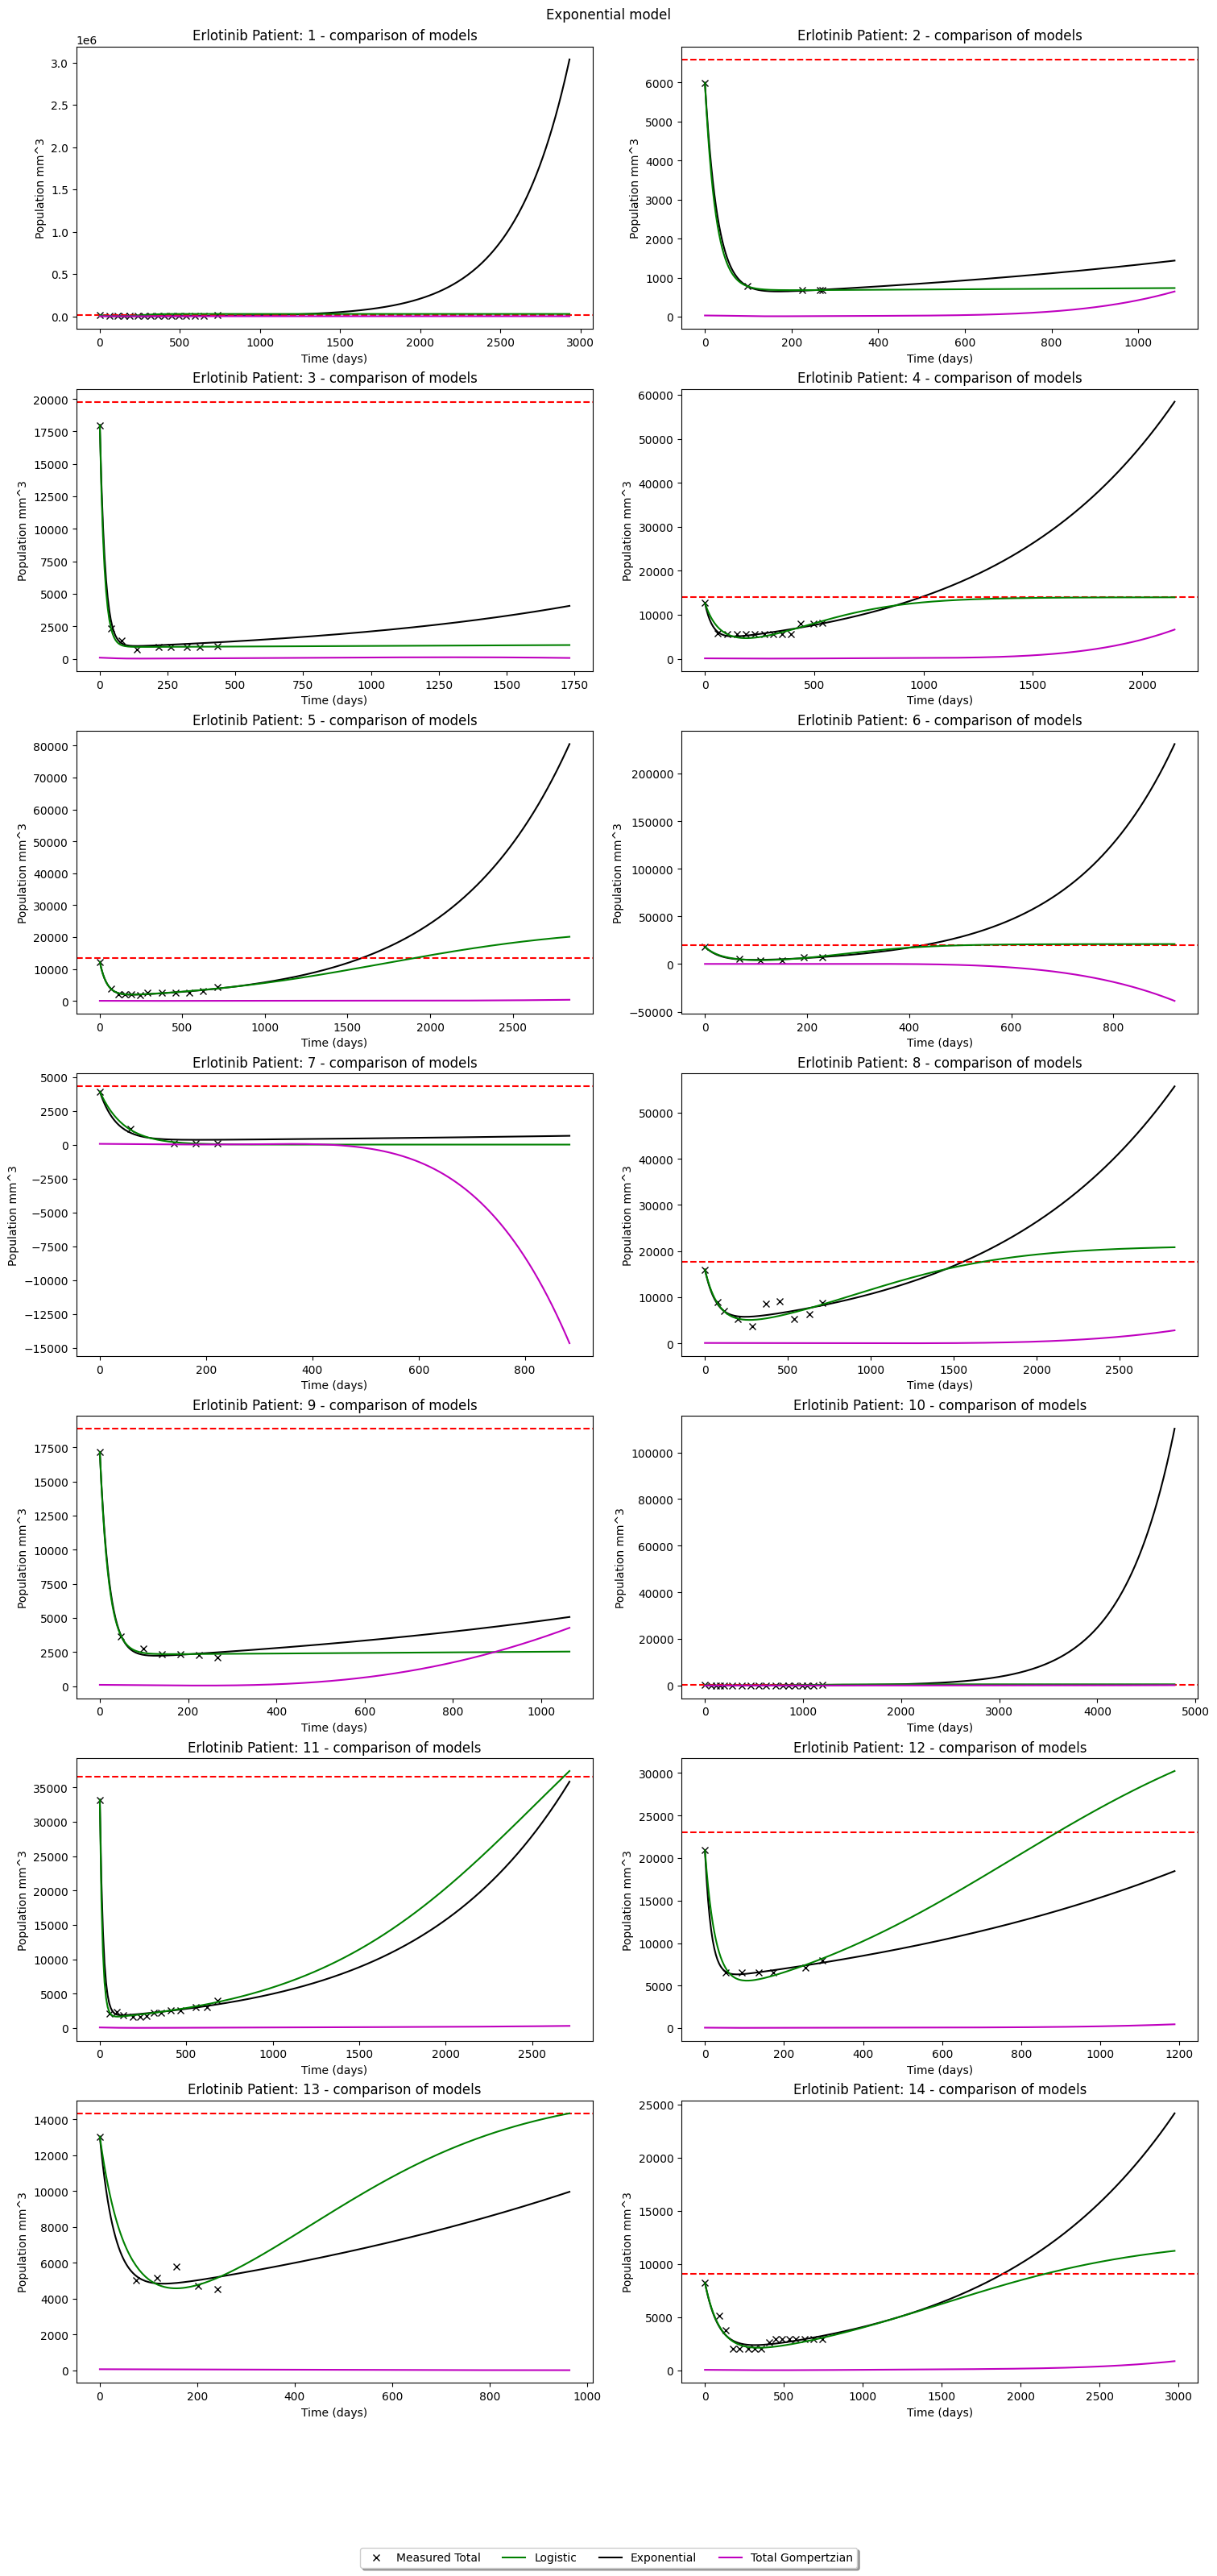

In [11]:
# multiple plots exp, log and gompertz
import pickle

with open('master_dictionary_log.pkl', 'rb') as f:
    master_dictionary_log = pickle.load(f)

with open('master_dictionary_gomp.pkl', 'rb') as f:
    master_dictionary_gomp = pickle.load(f)

n = len(unique_IDs) 
ncols = 2
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 30), constrained_layout=True)

sim_time_factor = 4

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    tspan = np.linspace(0, sim_time_factor*days[-1], 300)

    optimal_params = master_dictionary[id]
    init_populations = [optimal_params[3], data[0]-optimal_params[3]]

    pred_data = solve_ivp(system_ode_rk45, [0,sim_time_factor*days[-1]],
                            init_populations, dense_output=True,
                            args = tuple([optimal_params[:3]]))
    sum_pops = np.sum(pred_data.sol(tspan), axis=0)

# fitting for logistic

    optimal_params_log = master_dictionary_log[id]
    init_populations_log = [optimal_params_log[3],data[0]-optimal_params_log[3]]
    pred_data_log = solve_ivp(system_ode_logistic, [0,sim_time_factor*days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:3]]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)

# fitting for gompertz
    optimal_params_gom = master_dictionary_gomp[id]
    init_populations_gom = optimal_params_gom[3:-1]

    pred_data_gom = solve_ivp(system_ode_gompertizian, [0,days[-1]],
                            init_populations_gom, dense_output=True,
                            args = tuple([optimal_params_gom[:3]]))
    sum_pops_gom = np.sum(pred_data_gom.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    #ax.plot(tspan, pred_data.sol(tspan)[0], 'b-', label='Sensitive')
    #ax.plot(tspan, pred_data.sol(tspan)[1], 'r-', label='Resistant') 
    ax.plot(tspan, sum_pops, 'k-', label='Total')
    ax.axhline(y=1.1*data[0], color='r', linestyle='--') ### line to show progression
    ax.plot(tspan, sum_pops_log, 'g-', label='Logistic')
    ax.plot(tspan, sum_pops_gom, 'm-', label='Gompertz')

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Population mm^3')
    ax.set_title(f'Erlotinib Patient: {index+1} - comparison of models') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                  Line2D([0], [0], color='g', linestyle= '-' ,label='Logistic'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Exponential'),
                   Line2D([0], [0], color='m', linestyle= '-' ,label='Total Gompertzian')]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Exponential model')  
plt.show()

##### MTD vs 1/2 MTD


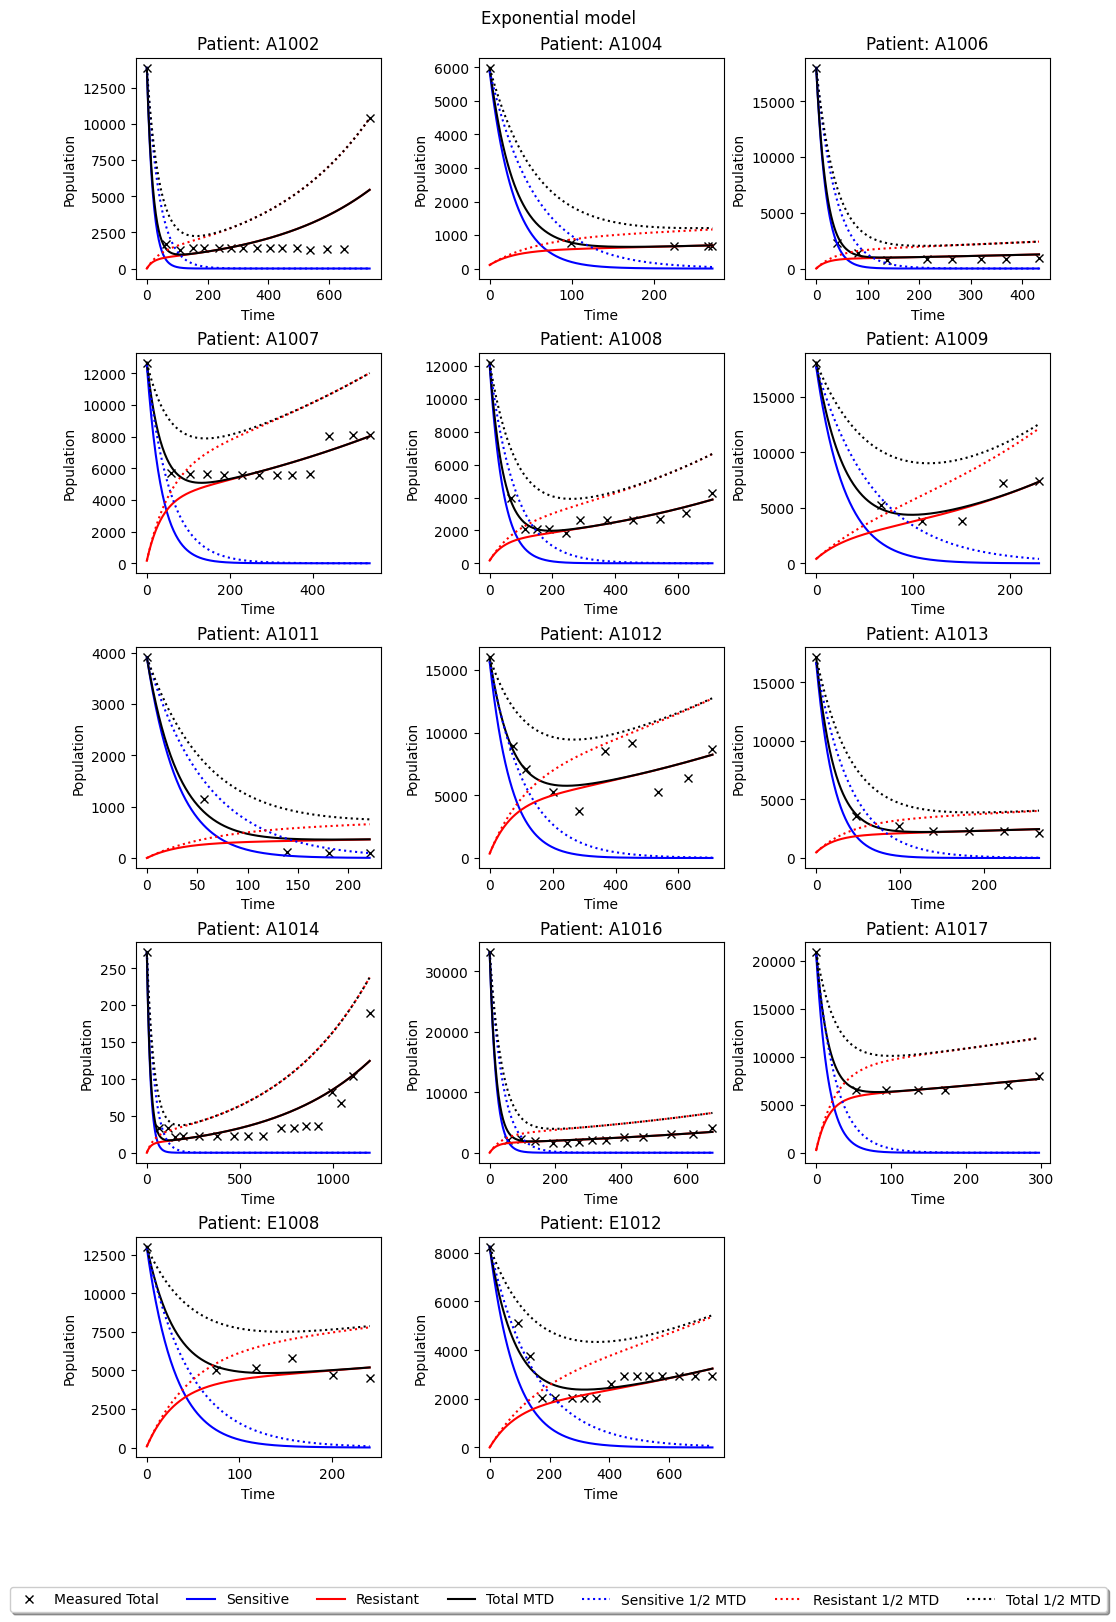

In [12]:
master_dictionary_copy = copy.deepcopy(master_dictionary) # deep to create a copy that can be changed
for key in master_dictionary_copy:
    master_dictionary_copy[key][2] *= 0.5

# setting up subplots   
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params = master_dictionary[id]
    init_populations = [optimal_params[3], data[0]-optimal_params[3]]

    pred_data = solve_ivp(system_ode_rk45, [0,days[-1]],
                            init_populations, dense_output=True,
                            args = tuple([optimal_params[:3]]))
    sum_pops = np.sum(pred_data.sol(tspan), axis=0)

# half dose
    optimal_params_half = master_dictionary_copy[id]
    init_populations_half = [optimal_params_half[3], data[0]-optimal_params_half[3]]

    pred_data_half = solve_ivp(system_ode_rk45, [0,days[-1]],
                            init_populations_half, dense_output=True,
                            args = tuple([optimal_params_half[:3]]))
    sum_pops_half = np.sum(pred_data_half.sol(tspan), axis=0)



#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data.sol(tspan)[0], 'b-', label='Sensitive') # plot exponential model
    ax.plot(tspan, pred_data.sol(tspan)[1], 'r-', label='Resistant') 
    ax.plot(tspan, sum_pops, 'k-', label='Total')

     # plot with half medication
    ax.plot(tspan, pred_data_half.sol(tspan)[0], 'b:', label='Sensitive 0.5*MTD') 
    ax.plot(tspan, pred_data_half.sol(tspan)[1], 'r:', label='Resistant 0.5*MTD') 
    ax.plot(tspan, sum_pops_half, 'k:', label='Total 0.5*MTD')
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive'),
                   Line2D([0], [0], color='r', label='Resistant'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total MTD'),
                    Line2D([0], [0], color='b', linestyle=':', label='Sensitive 1/2 MTD'),
                   Line2D([0], [0], color='r', linestyle=':', label='Resistant 1/2 MTD'),
                   Line2D([0], [0], color='k', linestyle= ':' ,label='Total 1/2 MTD'),
                   ]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Exponential model')  
plt.show()

##### Adding medication term 
